In [1]:
import pyopia.background
import pyopia.classify
import pyopia.instrument.silcam
import pyopia.instrument.holo
import pyopia.io
import pyopia.pipeline
import pyopia.plotting
import pyopia.process
import pyopia.statistics
import exampledata

import xarray
import matplotlib.pyplot as plt

## Load a TOML config file containing all setttings, and pipeline steps

This creates a dict of all settings

In [2]:
toml_settings = pyopia.io.load_toml('config.toml')
toml_settings

{'general': {'raw_files': 'raw_data/*.silc', 'pixel_size': 24},
 'steps': {'classifier': {'pipeline_class': 'pyopia.classify.Classify',
   'model_path': 'keras_model.h5'},
  'createbackground': {'pipeline_class': 'pyopia.background.CreateBackground',
   'average_window': 10,
   'instrument_module': 'silcam'},
  'load': {'pipeline_class': 'pyopia.instrument.silcam.SilCamLoad'},
  'correctbackground': {'pipeline_class': 'pyopia.background.CorrectBackgroundAccurate',
   'bgshift_function': 'accurate'},
  'imageprep': {'pipeline_class': 'pyopia.instrument.silcam.ImagePrep',
   'image_level': 'imc'},
  'segmentation': {'pipeline_class': 'pyopia.process.Segment',
   'threshold': 0.85},
  'statextract': {'pipeline_class': 'pyopia.process.CalculateStats'},
  'output': {'pipeline_class': 'pyopia.io.StatsH5',
   'output_datafile': 'proc/test'}}}

## Run the pipeline

(same as normal)

In [3]:
# Initialise the pipeline and run the initial steps
processing_pipeline = pyopia.pipeline.Pipeline(toml_settings)

# Load an image (from the test suite)
filename = exampledata.get_example_silc_image()

# Process the image to obtain the stats dataframe
stats = processing_pipeline.run(filename)

Initialising pipeline
raw_files: raw_data/*.silc
Classify  ready with: {'model_path': 'keras_model.h5'}
CreateBackground  ready with: {'average_window': 10, 'instrument_module': 'silcam'}
Pipeline ready with these data:  ['settings', 'raw_files', 'cl', 'bgstack', 'imbg']
SilCamLoad  ready with: {}
CorrectBackgroundAccurate  ready with: {'bgshift_function': 'accurate'}
ImagePrep  ready with: {'image_level': 'imc'}
Segment  ready with: {'threshold': 0.85}
segment
clean
CalculateStats  ready with: {}
statextract
23.5% saturation
measure
  1384 particles found
WARNING. exportparticles temporarily modified for 2-d images without color!
EXTRACTING 1382 IMAGES from 1384
StatsH5  ready with: {'output_datafile': 'proc/test'}


## Load the data again

Then later, we can load the data again from NetCDF using xarray

xarray DataSets are presented nicely in notebooks

In [4]:
with xarray.open_dataset('proc/test-STATS.nc') as xstats:
    xstats.load()

xstats

<xarray.Dataset>
Dimensions:                     (index: 1384)
Coordinates:
  * index                       (index) int32 0 1 2 3 4 ... 1380 1381 1382 1383
    time                        (index) datetime64[ns] 2018-11-01T14:27:31.83...
Data variables: (12/17)
    export name                 (index) object 'D20181101T142731.838206-PN0' ...
    major_axis_length           (index) float64 6.8 87.33 8.721 ... 14.41 10.08
    minor_axis_length           (index) float64 3.183 75.48 ... 12.96 6.985
    equivalent_diameter         (index) float64 4.514 69.51 ... 13.59 8.368
    minr                        (index) float64 3.0 4.0 ... 2.027e+03 2.028e+03
    minc                        (index) float64 1.003e+03 635.0 ... 766.0
    ...                          ...
    probability_faecal_pellets  (index) float64 0.00343 0.00343 ... 0.00343
    probability_copepod         (index) float64 0.002331 0.002331 ... 0.002331
    probability_diatom_chain    (index) float64 0.005164 0.005164 ... 0.005164
    probability_oily_gas        (index) float64 0.1086 0.1086 ... 0.1086 0.1086
    timestamp                   (index) datetime64[ns] 2018-11-01T14:27:31.83...
    saturation                  (index) float64 23.48 23.48 ... 23.48 23.48
Attributes:
    steps:           [general]\nraw_files = "raw_data/*.silc"\npixel_size = 2...
    Modified:        2023-08-28 13:17:07.361901
    PyOpia version:  0.0.55

## Alter settings and re-process

What if we wanted to re-process this dataset with a different segmentation threshold?

### Get the TOML steps from the xarray DataSet

In [5]:
toml_steps = pyopia.pipeline.steps_from_xstats(xstats)
toml_steps

{'general': {'raw_files': 'raw_data/*.silc', 'pixel_size': 24},
 'steps': {'classifier': {'pipeline_class': 'pyopia.classify.Classify',
   'model_path': 'keras_model.h5'},
  'createbackground': {'pipeline_class': 'pyopia.background.CreateBackground',
   'average_window': 10,
   'instrument_module': 'silcam'},
  'load': {'pipeline_class': 'pyopia.instrument.silcam.SilCamLoad'},
  'correctbackground': {'pipeline_class': 'pyopia.background.CorrectBackgroundAccurate',
   'bgshift_function': 'accurate'},
  'imageprep': {'pipeline_class': 'pyopia.instrument.silcam.ImagePrep',
   'image_level': 'imc'},
  'segmentation': {'pipeline_class': 'pyopia.process.Segment',
   'threshold': 0.85},
  'statextract': {'pipeline_class': 'pyopia.process.CalculateStats'},
  'output': {'pipeline_class': 'pyopia.io.StatsH5',
   'output_datafile': 'proc/test'}}}

### Alter the setting we want to change

In [6]:
toml_steps['steps']['segmentation']['threshold'] = 0.9

### re-process the pipeline

In [7]:
# Initialise the pipeline and run the initial steps
processing_pipeline = pyopia.pipeline.Pipeline(toml_steps)

# Load an image (from the test suite)
filename = exampledata.get_example_silc_image()

# Process the image to obtain the stats dataframe
stats = processing_pipeline.run(filename)

Initialising pipeline
raw_files: raw_data/*.silc
Classify  ready with: {'model_path': 'keras_model.h5'}
CreateBackground  ready with: {'average_window': 10, 'instrument_module': 'silcam'}
Pipeline ready with these data:  ['settings', 'raw_files', 'cl', 'bgstack', 'imbg']
SilCamLoad  ready with: {}
CorrectBackgroundAccurate  ready with: {'bgshift_function': 'accurate'}
ImagePrep  ready with: {'image_level': 'imc'}
Segment  ready with: {'threshold': 0.9}
segment
clean
CalculateStats  ready with: {}
statextract
27.5% saturation
measure
  2001 particles found
WARNING. exportparticles temporarily modified for 2-d images without color!
EXTRACTING 1999 IMAGES from 2001
StatsH5  ready with: {'output_datafile': 'proc/test'}


### Further analysis

At this point we could write this to disc again (using the pyopia.io.write_stats function)

and/or we could build a new, correctly formatted, xarray for immediate use (which we will do here):

In [8]:
xstats_modified = pyopia.io.make_xstats(stats, toml_steps)
xstats_modified

<xarray.Dataset>
Dimensions:                     (index: 2001)
Coordinates:
  * index                       (index) int64 0 1 2 3 4 ... 1997 1998 1999 2000
    time                        (index) datetime64[ns] 2018-11-01T14:27:31.83...
Data variables: (12/17)
    major_axis_length           (index) float64 19.03 11.59 ... 4.996 9.136
    minor_axis_length           (index) float64 5.58 9.027 5.812 ... 4.384 7.651
    equivalent_diameter         (index) float64 7.818 9.901 ... 4.652 8.137
    minr                        (index) float64 3.0 4.0 ... 2.029e+03 2.033e+03
    minc                        (index) float64 889.0 913.0 ... 399.0 1.511e+03
    maxr                        (index) float64 19.0 16.0 ... 2.042e+03
    ...                          ...
    probability_copepod         (index) float64 0.002331 0.002331 ... 0.002331
    probability_diatom_chain    (index) float64 0.005164 0.005164 ... 0.005164
    probability_oily_gas        (index) float64 0.1086 0.1086 ... 0.1086 0.1086
    export name                 (index) object 'D20181101T142731.838206-PN0' ...
    timestamp                   (index) datetime64[ns] 2018-11-01T14:27:31.83...
    saturation                  (index) float64 27.52 27.52 ... 27.52 27.52
Attributes:
    steps:           [general]\nraw_files = "raw_data/*.silc"\npixel_size = 2...
    Modified:        2023-08-28 13:17:26.310477
    PyOpia version:  0.0.55

### Plotting

We can plot directly from xarray in exactly the same way as from the Pandas DataFrame (so it doesn't matter which you use here). The benefit of 'xstats' as an xarray is that it now contains it's own metadata

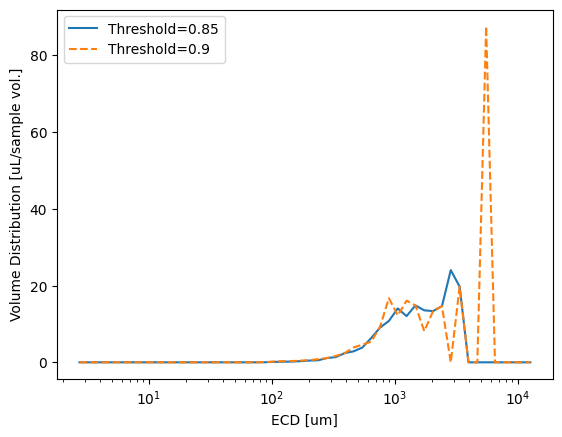

In [9]:
dias, vd = pyopia.statistics.vd_from_stats(xstats, pyopia.pipeline.steps_from_xstats(xstats)['general']['pixel_size'])

plt.plot(dias, vd, label=f"Threshold={pyopia.pipeline.steps_from_xstats(xstats)['steps']['segmentation']['threshold']}")
plt.xscale('log')
plt.xlabel('ECD [um]')
plt.ylabel('Volume Distribution [uL/sample vol.]')

dias_modified, vd_modified = pyopia.statistics.vd_from_stats(xstats_modified, pyopia.pipeline.steps_from_xstats(xstats_modified)['general']['pixel_size'])

plt.plot(dias_modified, vd_modified, '--', label=f"Threshold={pyopia.pipeline.steps_from_xstats(xstats_modified)['steps']['segmentation']['threshold']}")

plt.legend()